In [1]:
import pathlib
import scanpy as sp # '1.6.0'
import anndata as anndata # '0.7.4'

import numpy as np # '1.19.1'
import pandas as pd # '1.1.2'
import copy

import matplotlib.pyplot as plt # '3.3.2'
from matplotlib import colors
from matplotlib_scalebar.scalebar import ScaleBar # '0.6.2'

import tifffile # '2020.9.22'

import functools

import scipy
import scipy.stats

import re

import plotnine as gg

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import warnings


In [103]:
%matplotlib ipympl

In [58]:
%matplotlib inline

# TODO:
- save label objects as masks as well
- save dists into 'image' folder

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import plothelpers as plth

In [5]:
class C:
    # Folder containing the unziped dataset downloaded from zenodo
    # adapt if snakemake is not used
    fn_labels=pathlib.Path('../Damond2018/seg_comparison/Label.csv')
    fn_imgs=pathlib.Path('../Damond2018/seg_comparison/Image.csv')
    
    fn_label_var = pathlib.Path('../Damond2018/seg_comparison/var_Label.csv')
    fn_img_var = pathlib.Path('../Damond2018/seg_comparison/var_Image.csv')
    
class V:
    COL_DATATYPE = 'data_type'
    COL_COLUMN_NAME = 'column_name'
    is_float = 'float'
    label='label'
    
    label_meas = 'Intensity_MeanIntensity_LabelImg'


In [6]:
runs = ['Damond2018','Schulz2017', 'HubMAP2020' , 'Ali2020', 'Jackson2020']

In [7]:
def cp_to_ad(dat_meas, dat_var):
    """
    Converts cellprofiler output to anndata
    """
    var = dat_var.query(f'{V.COL_DATATYPE} == "{V.is_float}"')
    var = var.set_index(V.COL_COLUMN_NAME)
    obs = dat_meas.drop(columns=var.index)
    x = dat_meas[var.index]
    ad = sp.AnnData(x, obs=obs, var=var)
    return ad

def add_image_id(ad, run):
    """
    Adds an image id column
    """
    ad.obs['ImageId'] = ad.obs['ImageNumber'].map(lambda x: f'{run}_{x}')
    
def add_obj_id(ad, object_name):
    """
    Adds an object id column
    """
    ad.obs['ObjectId'] = ad.obs.apply(lambda row: f'{row["ImageId"]}_{object_name}_{row["ObjectNumber"]}', axis=1)
    
def get_ad_img(dat_meas, dat_var, run='run1'):
    """
    Converts the image metadata table
    """
    ad = cp_to_ad(dat_meas, dat_var)
    add_image_id(ad, run=run)
    ad.obs = ad.obs.set_index('ImageId')
    return ad

def get_ad_obj(dat_meas, dat_var, run='run1', object_name='obj'):
    """
    Converts an object metadata table
    """
    ad = cp_to_ad(dat_meas, dat_var)
    ad.var['channel'] = ad.var['channel'].fillna(1)
    add_image_id(ad, run=run)
    add_obj_id(ad, object_name=object_name)
    ad.obs = ad.obs.set_index('ObjectId')
    ad.uns['ObjectName'] = object_name
    return ad

def scale_measurements(ad_obj, ad_img):
    for imgname, g in ad_obj.var.loc[~ad_obj.var['image_name'].isna(),:].groupby('image_name'):
        v = ad_img.var.query(f'image_name == "{imgname}" & feature_name == "Scaling"')
        if len(v.index) > 0:
            scaling = ad_img.obs_vector(v.index[0])
            assert np.allclose(scaling, scaling[0]), "Not all images scaled equal! Scaling currently not implemented for this case."
            ad_obj[:,g.index].X = ad_obj[:,g.index].X*scaling[0]

In [8]:
def map_group_re(x, re_str):
    """
    Maps a regular expression with matchgroups
    to a iterable (e.g. column in a dataframe) and returns the
    result as a data frame
    Args:
        x: iterable
        re_str: a regular expression string with matchgroups
    Return:
        A dataframe with column names being matchgroups
    """
    qre = re.compile(re_str)
    m_list = [
        pd.DataFrame.from_dict([m.groupdict() for m in qre.finditer(s)]) for s in x
    ]
    res = pd.concat(m_list, ignore_index=True)
    if hasattr(x, 'index'):
        res.index = x.index
    return res

In [9]:
class ObjectRelations:
    MODULE = 'Module'
    RELATIONSHIP = 'Relationship'
    FIRST_OBJ_NAME = 'First Object Name'
    SECOND_OBJ_NAME = 'Second Object Name'
    FIRST_OBJ_NUMBER = 'First Object Number'
    SECOND_OBJ_NUMBER = 'Second Object Number'
    FIRST_IMG_NUMBER = 'First Image Number'
    SECOND_IMG_NUMBER = 'Second Image Number'
    
    OBJ_NUMBER = 'ObjectNumber'
    IMG_NUMBER = 'ImageNumber'
    
    NEIGHBORS = 'Neighbors'
    CHILD = 'Child'
    PARENT = 'Parent'
    
    def __init__(self, dat_obj_rel):
        neighbours = {}
        parent = {}
        child = {}
        for (rel, f, s), d in (dat_obj_rel
                               .groupby([self.RELATIONSHIP,
                                         self.FIRST_OBJ_NAME,
                                         self.SECOND_OBJ_NAME])):
            if rel == self.NEIGHBORS:
                neighbours[f] = d[[self.FIRST_OBJ_NUMBER,
                                  self.FIRST_IMG_NUMBER,
                                  self.SECOND_OBJ_NUMBER,
                                  self.SECOND_IMG_NUMBER]]
            elif rel == self.CHILD:
                dic = child.get(f, {})
                dic[s] = d[[self.FIRST_OBJ_NUMBER,
                                  self.FIRST_IMG_NUMBER,
                                  self.SECOND_OBJ_NUMBER,
                                  self.SECOND_IMG_NUMBER]]
                child[f] = dic
                
            elif rel == self.PARENT:
                dic = parent.get(f, {})
                dic[s] = d[[self.FIRST_OBJ_NUMBER,
                                  self.FIRST_IMG_NUMBER,
                                  self.SECOND_OBJ_NUMBER,
                                  self.SECOND_IMG_NUMBER]]
                parent[f] = dic
            else:
                warnings.WarningMessage(f'{rel} relationship not supported')
                
            self.neighbours = neighbours
            self.child = child
            self.parent = parent
                
    def get_vars_via_rel(self, rel, value_vars, objectname_1,  dat_1, objectname_2=None, dat_2=None):
        if rel == self.NEIGHBORS:
            assert (objectname_2 is None) or (objectname_2 == objectname_1), f'Objectnames need to agree for {rel}'
            dat_rel = self.neighbours[objectname_1]
            dat_2 = dat_1
        elif rel == self.CHILD:
            dat_rel = self.child[objectname_1][objectname_2]
        elif rel == self.PARENT:
            dat_rel = self.parent[objectname_1][objectname_2]
            
        dat_merged = (dat_1[[self.OBJ_NUMBER, self.IMG_NUMBER]].reset_index(drop=False)
         .merge(dat_rel, left_on=[self.OBJ_NUMBER, self.IMG_NUMBER],
                   right_on=[self.FIRST_OBJ_NUMBER, self.FIRST_IMG_NUMBER])
         .dropna()
         .drop(columns=[self.OBJ_NUMBER, self.IMG_NUMBER,
                       self.FIRST_OBJ_NUMBER, self.FIRST_IMG_NUMBER])
         .merge(dat_2[[self.OBJ_NUMBER, self.IMG_NUMBER, *value_vars]],
                   right_on=[self.OBJ_NUMBER, self.IMG_NUMBER],
                   left_on=[self.SECOND_OBJ_NUMBER, self.SECOND_IMG_NUMBER])
         .drop(columns=[self.OBJ_NUMBER, self.IMG_NUMBER,self.SECOND_OBJ_NUMBER, self.SECOND_IMG_NUMBER])
         .set_index('ObjectId')
        )
        return dat_merged                                   

In [10]:
class SegmentationData:
    LABELS = 'LabelObjImg'
    CELLMASK = 'Mask2x'
    def __init__(self, run, fn_images, fn_images_var):
        self.run = run
        self.objects = {}
        self.images = {}
        self.ad_img = self._get_ad_img(run, fn_images, fn_images_var)
        

        
    def add_label_meas(self, fn_labels, fn_labels_var):
        ad_lab = get_ad_obj(pd.read_csv(fn_labels), pd.read_csv(fn_labels_var), run=self.run,
                                   object_name=self.LABELS)
        scale_measurements(ad_lab, self.ad_img)
        ad_lab.obs['label_codes'] = ad_lab.obs_vector(V.label_meas).astype('int')-1
        ad_lab.obs['label'] =pd.Categorical.from_codes(ad_lab.obs['label_codes'] , categories=['center','border','background'])
        self.ad_lab = ad_lab
        self.objects[self.LABELS] = ad_lab
        return self
    
    def add_cellmask_meas(self, fn_cellmask, fn_cellmask_var):
        ad_mask = get_ad_obj(pd.read_csv(fn_cellmask), pd.read_csv(fn_cellmask_var), run=self.run,
                                   object_name=self.CELLMASK)
        scale_measurements(ad_mask, self.ad_img)
        self.ad_mask = ad_mask
        self.objects[self.CELLMASK] = ad_mask
        return self
    
    def add_iohelper(self, fol_images, fol_masks):
        ioh = plth.IoHelper(self.ad_img.obs,
                        fol_images=fol_images,
                        fol_masks=fol_masks)
        self.ioh = ioh
        return self
    
    def merge_img_meta(self, dat, meta_cols=('cropname', 'segimage', 'segsettings', 'run')):
        dat = dat.merge(self.ad_img.obs[list(meta_cols)], how='left',left_on='ImageId', right_index=True)
        return dat
    
    def get_plot_data(self, var_names, img_meta_cols=('cropname', 'segimage', 'segsettings', 'run'),
                     object_name=None):
        if object_name is None:
            object_name = self.LABELS
        ad_lab = self.objects[object_name]
        pdat = (ad_lab.obs
                 .join(pd.DataFrame(ad_lab[:, var_names].X, columns=var_names, index=ad_lab.obs.index))
               )
        if img_meta_cols is not None:
            pdat = self.merge_img_meta(pdat, meta_cols=img_meta_cols)
        return pdat
    
    def plot_imag_ad(self, ad, figsize=None, add_colorbar=True, bg_img=True,
                     bad_alpha=0, ax=None,
                     **kwargs):
        """
        Plots all objects contained in the anndata, plotting the individual images as columns.

        :param ad: an anndata with obs variables: 'image_id', 'object_type', 'object_number'
        :param chan: The channel (metal) to plot
        :param figsize: the output image size

        :returns: the figure object
        """
        assert ad.X.shape[1] == 1, "Subset the anndata until it has at most 1 value"
        imgids = ad.obs['ImageId'].unique()
        if ax is None:
            fig, axs = plt.subplots(ncols=len(imgids), figsize=figsize)
        else:
            assert len(imgids) == 1
            axs = [ax]
        try:
            len(axs)
        except:
            axs = [axs]
        object_name = ad.uns['ObjectName']
        for ax, (imid, dat) in zip(axs, ad.obs.groupby(['ImageId'])):
            mask = self.ioh.get_mask(imid, object_type=object_name)
            values = ad[dat.index, :].X.squeeze()
            labels = dat['ObjectNumber']
            img = plth.map_series_on_mask(mask, labels, values)

            colorbar = (ax == axs[-1]) and add_colorbar
            if bg_img:
                self.plot_bg_img(imid, ax=ax)
            plth.plot_heatmask(img, ax=ax, colorbar=colorbar, bad_alpha=bad_alpha, **kwargs)
            ax.axis('off')
        plth.adapt_ax_clims(axs)
        return axs
    
    def plot_bg_img(self, imgid, cmap=None, image_name='Mask2xBorderImg', ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        if cmap is None:
            cmap = colors.ListedColormap(['black', 'darkgrey'])
        img = self.ioh.get_image(imgid, image_name).astype(float)

        ax.imshow(img, cmap=cmap,
              interpolation='nearest', origin='lower')

    @staticmethod
    def _get_ad_img(run, fn_images, fn_images_var):
        ad_img = get_ad_img(pd.read_csv(fn_images), pd.read_csv(fn_images_var), run)
        re_meta = '(?P<cropname>.*)_(?P<segimage>.*)-(?P<segsettings>.*)'
        ad_img.obs = ad_img.obs.join(map_group_re(ad_img.obs['Metadata_base'], re_meta))
        ad_img.obs['run'] = run
        return ad_img
    
    @staticmethod
    def make_obs_categorical(ad, categorydict):
        for k, cats in categorydict.items():
            ad.obs[k] = pd.Categorical(ad.obs[k], categories=cats)
    
    def add_object_relations(self, fn_relations):
        self.obj_rel = ObjectRelations(pd.read_csv(fn_relations))
    
    @classmethod
    def from_runname(cls, run, base_folder='..', comparison_folder='seg_comparison_v3',
                    image_categories=None):
        
        fn_labels = pathlib.Path(f'{base_folder}/{run}/{comparison_folder}/Label.csv')
        fn_labels_var =  pathlib.Path(f'{base_folder}/{run}/{comparison_folder}/var_Label.csv')
        fn_imgs =  pathlib.Path(f'{base_folder}/{run}/{comparison_folder}/Image.csv')
        fn_imgs_var = pathlib.Path(f'{base_folder}/{run}/{comparison_folder}/var_Image.csv')
        fol_images = pathlib.Path(f'{base_folder}/{run}/{comparison_folder}/imgs')
        fol_masks = pathlib.Path(f'{base_folder}/{run}/{comparison_folder}/masks')
        fn_maskimg = pathlib.Path(f'{base_folder}/{run}/{comparison_folder}/Mask2x.csv')
        fn_maskimg_var = pathlib.Path(f'{base_folder}/{run}/{comparison_folder}/var_Mask2x.csv')
        fn_object_relations = pathlib.Path(f'{base_folder}/{run}/{comparison_folder}/Object relationships.csv')
        segdata = cls(run, fn_imgs, fn_imgs_var)
        segdata.add_label_meas(fn_labels, fn_labels_var)
        segdata.add_cellmask_meas(fn_maskimg, fn_maskimg_var)
        segdata.add_iohelper(fol_images, fol_masks)
        if image_categories is not None:
            segdata.make_obs_categorical(segdata.ad_img, image_categories)
        
        segdata.add_object_relations(fn_object_relations)
        return segdata 

In [11]:
def plot_labels_on_mask(ioh, imgid, label_alpha=0.7, ax=None):
    cmap = colors.ListedColormap(['black', 'darkgrey'])
    bounds=[0,0.5,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(ioh.get_image(imgid, 'Mask2xBorderImg'), cmap=cmap,  norm=norm,
              interpolation='nearest', origin='lower')
    
    cmap_labs = colors.ListedColormap(['black', 'red', 'green', 'blue'])
    cmap_labs.set_bad(alpha=0)
    
    bounds=[0,257, 514,771, 1000]
    norm_labs = colors.BoundaryNorm(bounds, cmap_labs.N)
    img = ioh.get_image(imgid, 'LabelImg').astype(float)
    img[img == 0] = np.nan
    ax.imshow(img, cmap=cmap_labs,  norm=norm_labs,
              interpolation='nearest', origin='lower', alpha=label_alpha)

In [12]:
image_categories = {
    'segimage': ['FullProbabilities',
                'ProbabilitiesLoo',
                'nuclear'],
    'segsettings': [f'minsize{i}' for i in range(2,13,2)]
}

In [13]:
segdats = {run: SegmentationData.from_runname(run, comparison_folder='seg_comparison_v4', image_categories=image_categories) for run in runs}

/data/vizano/conda/seganalysis/lib/python3.8/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
/data/vizano/conda/seganalysis/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.


In [14]:
# Add information how much touching cells bellow a label are

for cur_seg in segdats.values():
    objr = cur_seg.obj_rel
    x=objr.get_vars_via_rel(objr.PARENT, ['Neighbors_PercentTouching_Adjacent'], 'Label', cur_seg.ad_lab.obs,
                            cur_seg.CELLMASK,  cur_seg.get_plot_data(['Neighbors_PercentTouching_Adjacent'],img_meta_cols=None,
                                                                    object_name=cur_seg.CELLMASK)

    )
    cur_seg.ad_lab.obs = cur_seg.ad_lab.obs.join(x.groupby('ObjectId').min(), how='left')

In [15]:
cur_seg.ad_lab.obs

,ImageNumber,ObjectNumber,Children_Mask2x_Count,Distance_Centroid_Mask2x,Distance_Minimum_Mask2x,Number_Object_Number,Parent_Mask2x,ImageId,label_codes,label,Neighbors_PercentTouching_Adjacent
ObjectId,,,,,,,,,,,
Jackson2020_1_LabelObjImg_1,1,1,1,4.220934,5.909169,1,7,Jackson2020_1,1,border,52.343750
Jackson2020_1_LabelObjImg_2,1,2,1,4.417867,6.033552,2,7,Jackson2020_1,0,center,41.935482
Jackson2020_1_LabelObjImg_3,1,3,1,1.390014,10.592830,3,10,Jackson2020_1,0,center,0.000000
Jackson2020_1_LabelObjImg_4,1,4,1,3.006081,3.163891,4,12,Jackson2020_1,0,center,77.777779
Jackson2020_1_LabelObjImg_5,1,5,1,5.518668,0.687184,5,11,Jackson2020_1,1,border,83.928574
...,...,...,...,...,...,...,...,...,...,...,...
Jackson2020_432_LabelObjImg_28,432,28,0,NaN,NaN,28,0,Jackson2020_432,2,background,NaN
Jackson2020_432_LabelObjImg_29,432,29,5,2.260452,2.237821,29,226,Jackson2020_432,1,border,73.333336
Jackson2020_432_LabelObjImg_30,432,30,0,1.745259,2.526410,30,226,Jackson2020_432,0,center,NaN


In [16]:
cur_seg = segdats['Jackson2020']

In [17]:
cur_seg.ad_img.obs['cropname'].nunique()

24

In [18]:
vars_meas = ['Intensity_MeanIntensity_MaskDistance',
             'Intensity_MaxIntensity_MaskDistance',
             'Intensity_MinIntensity_MaskDistance',
             'Intensity_MedianIntensity_MaskDistance',
              'Intensity_UpperQuartileIntensity_MaskDistance',
              'AreaShape_Area'
                ]

In [19]:

pdat = pd.concat([cur_seg.get_plot_data(vars_meas) for cur_seg in segdats.values()])

In [20]:
pdat['run'] = pd.Categorical(pdat['run'], categories=list((runs)))

In [21]:
pdat['run'] 

ObjectId
Damond2018_1_LabelObjImg_1         Damond2018
Damond2018_1_LabelObjImg_2         Damond2018
Damond2018_1_LabelObjImg_3         Damond2018
Damond2018_1_LabelObjImg_4         Damond2018
Damond2018_1_LabelObjImg_5         Damond2018
                                     ...     
Jackson2020_432_LabelObjImg_28    Jackson2020
Jackson2020_432_LabelObjImg_29    Jackson2020
Jackson2020_432_LabelObjImg_30    Jackson2020
Jackson2020_432_LabelObjImg_31    Jackson2020
Jackson2020_432_LabelObjImg_32    Jackson2020
Name: run, Length: 105678, dtype: category
Categories (5, object): ['Damond2018', 'Schulz2017', 'HubMAP2020', 'Ali2020', 'Jackson2020']

In [54]:
x= cur_seg.ad_mask[:, 'Neighbors_PercentTouching_Adjacent'].X.flatten()
plt.hist(np.array(x))

(array([  960.,   459.,  1034.,  1464.,  1942.,  3654.,  5457.,  7635.,
         6327., 36730.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.],
       dtype=float32),
 <BarContainer object of 10 artists>)

In [55]:
(pdat >> gg.ggplot(gg.aes(x='segsettings', y='Intensity_MeanIntensity_MaskDistance'))
     + gg.facet_grid('label~run', scales='free_y')
     + gg.geom_boxplot(gg.aes(fill='segimage'))
     + gg.theme(figure_size=(15,5))
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (8773988329162)>

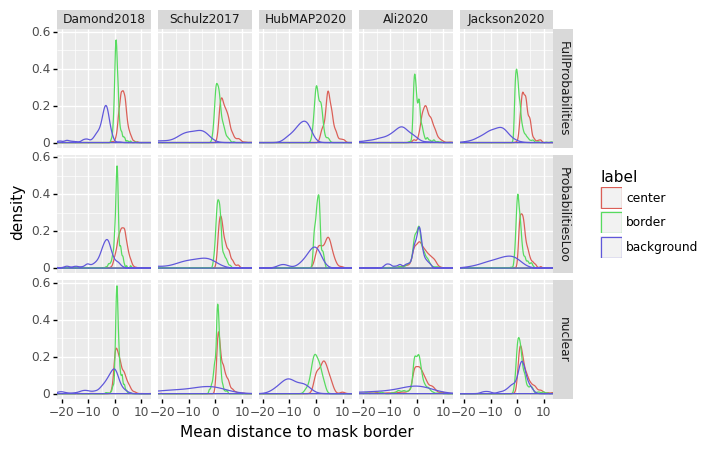

<ggplot: (8773983807877)>

In [59]:
(pdat.query('segsettings=="minsize6"') >>
     gg.ggplot(gg.aes(x='Intensity_MeanIntensity_MaskDistance'))
     + gg.facet_grid('segimage~run')
     +gg.geom_density(gg.aes(color='label'))
     + gg.coord_cartesian(xlim=(-20,12))
     + gg.xlab('Mean distance to mask border')
     
)

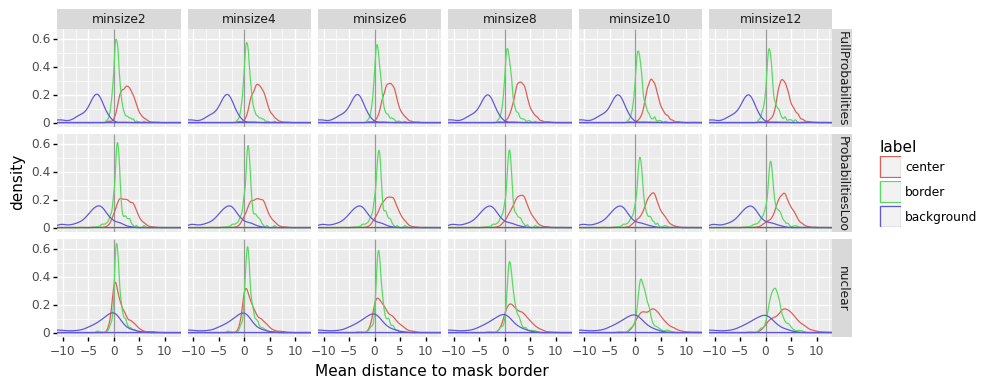

<ggplot: (8773973285503)>

In [75]:
(pdat
     .query('run == "Damond2018"')>>
     gg.ggplot(gg.aes(x='Intensity_MeanIntensity_MaskDistance'))
     + gg.facet_grid('segimage~segsettings')
       +gg.geom_vline(xintercept=0,alpha=0.4)
     +gg.geom_density(gg.aes(color='label'))
     + gg.coord_cartesian(xlim=(-10,12))
     + gg.xlab('Mean distance to mask border')
     + gg.theme(figure_size=(10,4))

     
)

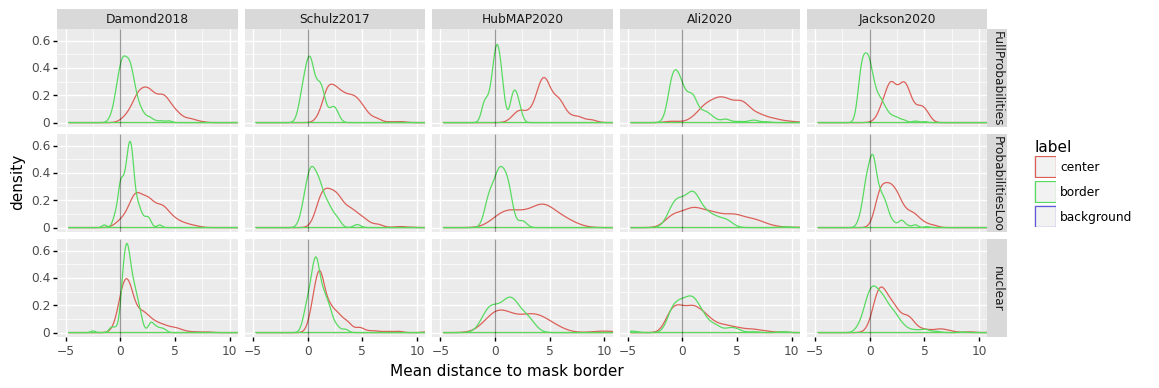

<ggplot: (8773972254645)>

In [93]:
(pdat.query('segsettings=="minsize6"') 
     .query('label != "background"')
      .query('Neighbors_PercentTouching_Adjacent > 90')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MeanIntensity_MaskDistance'))
     + gg.facet_grid('segimage~run')
     +gg.geom_density(gg.aes(color='label'))
     + gg.coord_cartesian(xlim=(-5,10))
      + gg.geom_vline(xintercept=0, alpha=0.4)
      + gg.xlab('Mean distance to mask border')
      + gg.theme(figure_size=(12,4))
     
)

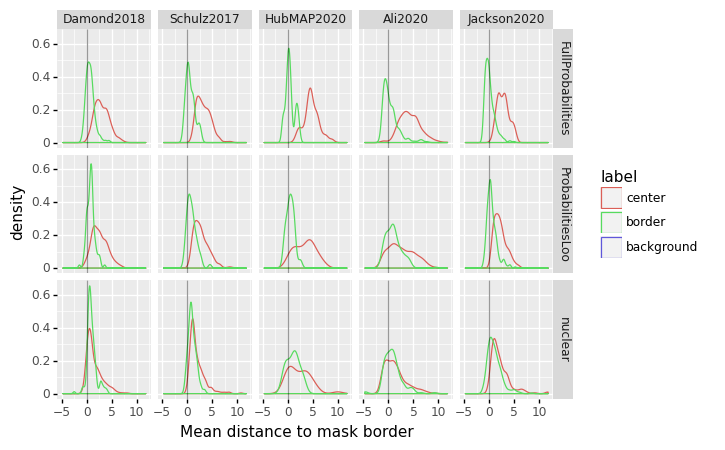

<ggplot: (8773979100721)>

In [61]:
(pdat.query('segsettings=="minsize6"') 
     .query('label != "background"')
     .query('Neighbors_PercentTouching_Adjacent > 90')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MeanIntensity_MaskDistance'))
     + gg.facet_grid('segimage~run')
     +gg.geom_density(gg.aes(color='label'))
     + gg.coord_cartesian(xlim=(-5,12))
      + gg.geom_vline(xintercept=0, alpha=0.4)
       + gg.xlab('Mean distance to mask border')
     
)

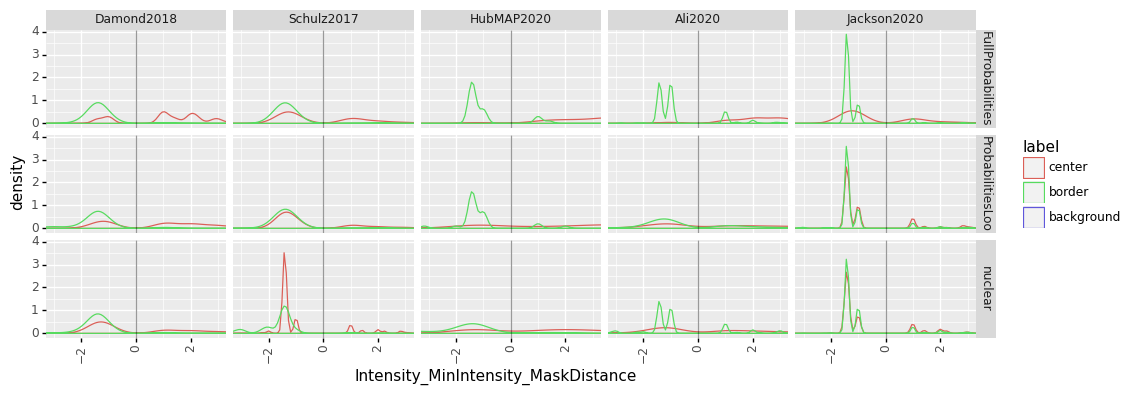

<ggplot: (8773978988659)>

In [102]:
(pdat.query('segsettings=="minsize6"') 
     .query('label != "background"')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MinIntensity_MaskDistance'))
     + gg.facet_grid('segimage~run')
     +gg.geom_density(gg.aes(color='label'))
     + gg.coord_cartesian(xlim=(-3,3))
      + gg.geom_vline(xintercept=0, alpha=0.4)
      + gg.theme(axis_text_x = gg.element_text(angle = 90), 
                figure_size=(12,4))
     
)

In [ ]:
(pdat.query('segsettings=="minsize6"') 
     .query('label != "background"')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MinIntensity_MaskDistance'))
     + gg.facet_grid('segimage~run')
     +gg.geom_density(gg.aes(color='label'))
     + gg.coord_cartesian(xlim=(-3,3))
      + gg.geom_vline(xintercept=0, alpha=0.4)
      + gg.theme(axis_text_x = gg.element_text(angle = 90), 
                figure_size=(12,4))
     
)

In [100]:
frac_misseg = (pdat.groupby(['segsettings', 'label', 'segimage', 'run'])['Intensity_MinIntensity_MaskDistance']
               .agg(frac_misseg=lambda x: np.mean(x < -0)).reset_index().query('label == "center"')
              )
frac_misseg

,segsettings,label,segimage,run,frac_misseg
0,minsize2,center,FullProbabilities,Damond2018,0.327103
1,minsize2,center,FullProbabilities,Schulz2017,0.718129
2,minsize2,center,FullProbabilities,HubMAP2020,0.163934
3,minsize2,center,FullProbabilities,Ali2020,0.079470
4,minsize2,center,FullProbabilities,Jackson2020,0.756757
...,...,...,...,...,...
235,minsize12,center,nuclear,Damond2018,0.282376
236,minsize12,center,nuclear,Schulz2017,0.527485
237,minsize12,center,nuclear,HubMAP2020,0.131148
238,minsize12,center,nuclear,Ali2020,0.381457


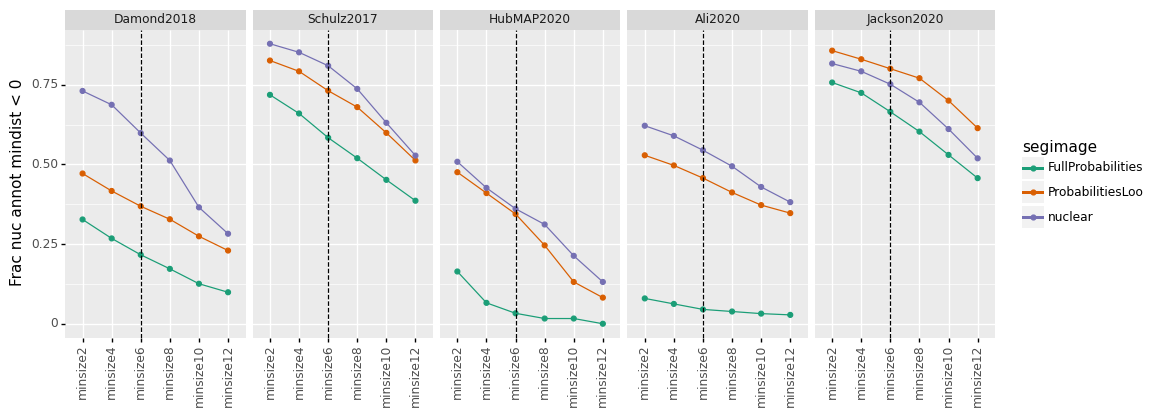

<ggplot: (8773968444462)>

In [99]:
(frac_misseg >>
    gg.ggplot(gg.aes(x='segsettings', y='frac_misseg',
                    color='segimage'))
      + gg.facet_grid('.~run')

     + gg.geom_line(gg.aes(group='segimage'))

     + gg.geom_point()
     + gg.expand_limits(y=0)
     + gg.ylab('Frac nuc annot mindist < 0')
       +gg.geom_vline(xintercept=3, linetype = "dashed")
     + gg.scale_color_brewer(type='qual', palette=2)
     + gg.theme(axis_text_x = gg.element_text(angle = 90), 
                figure_size=(12,4))
     + gg.xlab('')
        
     
)

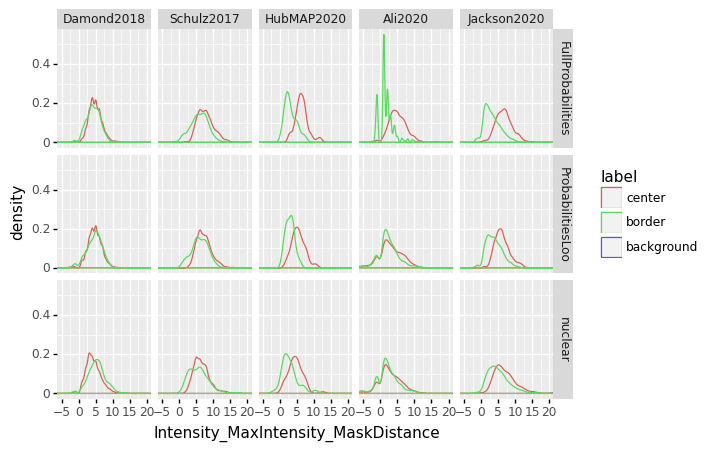

<ggplot: (8773978056759)>

In [65]:
(pdat.query('segsettings=="minsize8"') 
     .query('label != "background"')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MaxIntensity_MaskDistance'))
     + gg.facet_grid('segimage~run')
     +gg.geom_density(gg.aes(color='label'))
      + gg.coord_cartesian(xlim=(-5,20))
     
)

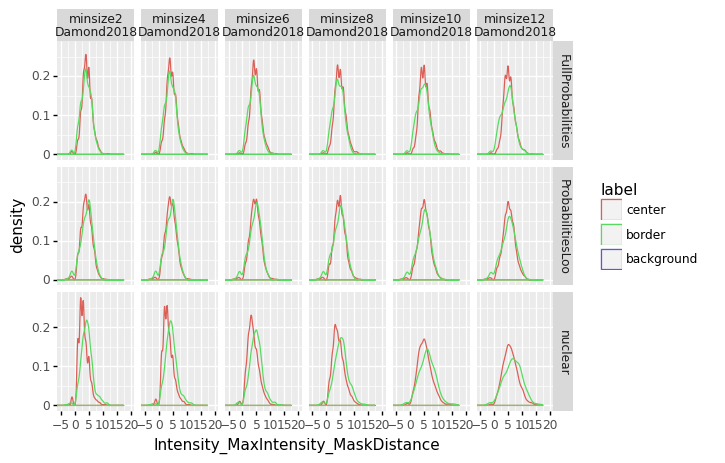

<ggplot: (8773977595200)>

In [66]:
(pdat.query('run=="Damond2018"') 
     .query('label != "background"')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MaxIntensity_MaskDistance'))
     + gg.facet_grid('segimage~segsettings+run')
     +gg.geom_density(gg.aes(color='label'))
      + gg.coord_cartesian(xlim=(-5,20))
     
)

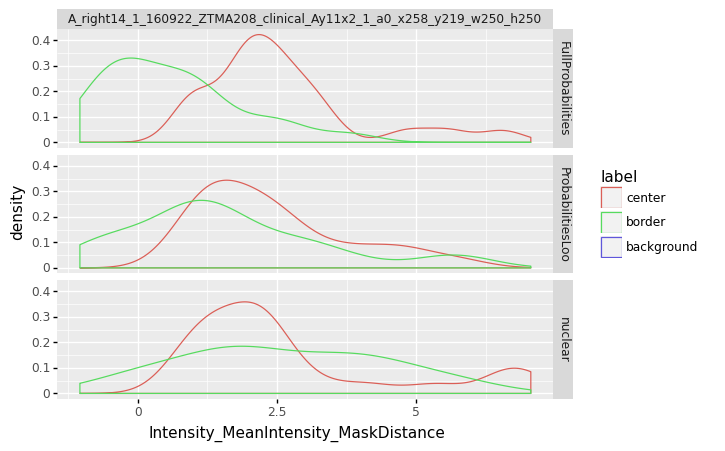

<ggplot: (8773976974936)>

In [67]:
d = (pdat.query('segsettings=="minsize8"') 
     .query('label != "background"')
     .query(f'cropname == "{pdat.cropname.sample(1)[0]}"'))
(d
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MeanIntensity_MaskDistance'))
     + gg.facet_grid('segimage~cropname')
     +gg.geom_density(gg.aes(color='label'))
     
)

In [33]:
levels = ['FullProbabilities', 'ProbabilitiesLoo', 'nuclear']

In [34]:
d['segimage'] = pd.Categorical(d['segimage'], categories=levels)

In [35]:
segdats['Damond2018'].ad_img.obs.columns

Index(['Channel_LabelImg', 'Channel_Mask', 'Count_Label', 'Count_Mask2x',
       'Count_Mask2xBorder', 'FileName_LabelImg', 'FileName_LabelObjImg',
       'FileName_Mask', 'FileName_Mask2xBorderImg', 'FileName_Mask2xImg',
       'FileName_MaskDistanceRescaled', 'Frame_LabelImg', 'Frame_Mask',
       'Group_Index', 'Group_Number', 'Height_LabelImg', 'Height_Mask',
       'ImageNumber', 'ImageSet_ImageSet', 'MD5Digest_LabelImg',
       'MD5Digest_Mask', 'Metadata_FileLocation', 'Metadata_Frame',
       'Metadata_Series', 'Metadata_base', 'ModuleError_01Images',
       'ModuleError_02Metadata', 'ModuleError_03NamesAndTypes',
       'ModuleError_04Groups', 'ModuleError_05ConvertImageToObjects',
       'ModuleError_06Resize', 'ModuleError_07ConvertImageToObjects',
       'ModuleError_08ExpandOrShrinkObjects',
       'ModuleError_09ConvertObjectsToImage',
       'ModuleError_10ConvertObjectsToImage', 'ModuleError_11TransformBinary',
       'ModuleError_12RescaleIntensity',
       'ModuleErro

In [36]:
def plot_minsizes(segdat, segimage,cropname=None):
    if cropname is None:
        cropname = segdat.ad_img.obs['cropname'].sample(1).values[0]
        print(cropname)
        
    settings =segdat.ad_img.obs.query(f'cropname =="{cropname}" and segimage == "{segimage}"')['segsettings'].sort_values()
    fig, axs = plt.subplots(ncols=len(settings))
    for ax, aset, imgid in zip(axs, settings, settings.index):
        print(aset)
        plot_labels_on_mask(segdat.ioh, imgid, ax=ax)
        ax.set_title(aset, fontsize=3)
        ax.axis('off')
    

In [37]:
def plot_minsizes_all(segdat, cropname=None):
    if cropname is None:
        cropname = segdat.ad_img.obs['cropname'].sample(1).values[0]
        print(cropname)
        
    d =segdat.ad_img.obs.query(f'cropname =="{cropname}"')[['segsettings', 'segimage']]
    
    fig, axs = plt.subplots(ncols=d['segsettings'].nunique(), nrows=d['segimage'].nunique(),sharex=True, sharey=True)
    for i, (segimage, g) in enumerate(d.groupby('segimage')):
        g = g['segsettings'].sort_values()
        for j, segsettings in enumerate(g):
            ax = axs[i][j]
            plot_labels_on_mask(segdat.ioh, g.index[j], ax=ax)
            ax.set_title(segsettings, fontsize=5)
            if j == 0:
                ax.xaxis.set_ticks([])
                ax.yaxis.set_ticks([])
                ax.set_ylabel(segimage, fontsize=5)
            else:
                 ax.axis('off')
    return fig, axs
    
    


In [119]:
def plot_single(segdat, segsettings='minsize6', segimage='ProbabilitiesLoo', cropname=None):
    if cropname is None:
        cropname = segdat.ad_img.obs['cropname'].sample(1).values[0]
        print(cropname)
    d =segdat.ad_img.obs.query(f'cropname =="{cropname}" and segsettings == "{segsettings}" and segimage == "{segimage}"')
    ax = plot_labels_on_mask(segdat.ioh, d.index[0])
    plt.gca().axis('off')
    return ax


In [173]:
plot_single(segdats['Damond2018'], cropname='O34_a0_x132_y256_w250_h250',  segsettings='minsize8')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [174]:
plot_single(segdats['HubMAP2020'], cropname='20191202_HuBMAP_Thymus_s0_p8_r5_a5_ac_x1044_y793_w500_h500',  segsettings='minsize8')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [176]:
plot_single(segdats['Schulz2017'], cropname='8_10_F01_8_a0_x113_y501_w250_h250', segsettings='minsize8')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [144]:
plot_single(segdats['Jackson2020'], cropname='A_left14_2_160922_ZTMA208_clinical_Ay14x6_87_a0_x182_y679_w250_h250')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [167]:
plot_single(segdats['Ali2020'], cropname=None)


METABRIC_MBAD01A_24.6kx18.4ky_6000x6000_4_20161102_548_PS99.9304Q_15.6_7.2_101_a0_x90_y395_w500_h500


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [163]:
fig, axs = plot_minsizes_all(segdats['Damond2018'], cropname='M23_a0_x633_y429_w250_h250')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

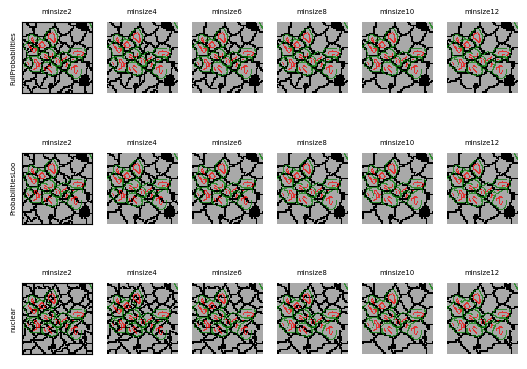

In [40]:
axs[0][0].set_xlim((60,150))
axs[0][0].set_ylim((60,150))
fig

In [41]:
plot_minsizes(segdats['Damond2018'], segimage='FullProbabilities')

B23_a0_x359_y90_w250_h250


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

minsize2
minsize4
minsize6
minsize8
minsize10
minsize12


In [42]:
fig, axs = plot_minsizes_all(segdats['Damond2018'], cropname='N60_a0_x639_y485_w250_h250')
axs[0][0].set_xlim((170,250))
axs[0][0].set_ylim((90,160))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(90.0, 160.0)

In [43]:
def plot_examples(pdat):
    for (_, run, imgid), g in d.groupby(['segimage', 'run', 'ImageId']):
        plot_labels_on_mask(segdats[run].ioh, imgid)
        plt.title(imgid)
plot_examples(d)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [44]:
(pdat
     .query('label != "background"')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MeanIntensity_MaskDistance'))
     + gg.facet_grid('segimage~segsettings')
     + gg.geom_density(gg.aes(color='label'))
     + gg.geom_vline(xintercept=0, alpha=0.4)
     +gg.theme(figure_size=(15,5))
     
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (8773994493450)>

In [45]:
(pdat
     .query('run  == "Damond2018"')
     .query('label != "background"')
      .query('Neighbors_PercentTouching_Adjacent > 90')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MeanIntensity_MaskDistance'))
     + gg.facet_grid('segimage~segsettings')
     + gg.geom_density(gg.aes(color='label'))
     + gg.geom_vline(xintercept=0, alpha=0.4)
     +gg.theme(figure_size=(15,5))
     
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (8773992273713)>

In [46]:
(pdat
     .query('label != "background"')
      .query('run  == "Damond2018"')
     .query('label != "background"')
      .query('Neighbors_PercentTouching_Adjacent > 90')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MinIntensity_MaskDistance'))
     + gg.facet_grid('segimage~segsettings')
     + gg.geom_density(gg.aes(color='label'))
     + gg.geom_vline(xintercept=0, alpha=0.4)
     +gg.theme(figure_size=(15,5))
     
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (8773991735435)>

In [47]:
(pdat
     .query('label != "background"')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MaxIntensity_MaskDistance'))
     + gg.facet_grid('segimage~segsettings')
     + gg.geom_density(gg.aes(color='label'))
     + gg.geom_vline(xintercept=0, alpha=0.4)
     +gg.theme(figure_size=(15,5))
     
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (8773991195685)>

In [48]:
(pdat
     .query('label != "background"')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_UpperQuartileIntensity_MaskDistance'))
     + gg.facet_grid('segimage~segsettings')
     + gg.geom_density(gg.aes(color='label'))
     + gg.geom_vline(xintercept=0, alpha=0.4)
     +gg.theme(figure_size=(15,5))
     
)

/data/vizano/conda/seganalysis/lib/python3.8/site-packages/plotnine/ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (8773990662123)>

In [49]:
(pdat
     .query('label != "background"')
     >>
     
     gg.ggplot(gg.aes(x='Intensity_MeanIntensity_MaskDistance'))
     + gg.facet_grid('segimage~segsettings')
     + gg.geom_histogram(gg.aes(color='label'))
     + gg.geom_vline(xintercept=0, alpha=0.4)
     +gg.theme(figure_size=(15,5))
     
)

/data/vizano/conda/seganalysis/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 666'. Pick better value with 'binwidth'.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (8773990133116)>

In [90]:
def get_wasserstein(dat,co=-2):
    center = dat.query(f'label == "center"')['Intensity_MeanIntensity_MaskDistance'].values.copy()
    border = dat.query(f'label == "border"')['Intensity_MeanIntensity_MaskDistance'].values.copy()
    
    center[center<co] = co
    border[border<co] = co
    if (len(center) == 0) | (len(border) == 0):
        return np.nan
    else:
        return scipy.stats.wasserstein_distance(center, border)

pdat.groupby(['run', 'segsettings', 'segimage']).apply(get_wasserstein)

run          segsettings  segimage         
Damond2018   minsize2     FullProbabilities    2.000792
                          ProbabilitiesLoo     1.652020
                          nuclear              0.567866
             minsize4     FullProbabilities    2.183026
                          ProbabilitiesLoo     1.810467
                                                 ...   
Jackson2020  minsize10    ProbabilitiesLoo     1.946949
                          nuclear              1.562277
             minsize12    FullProbabilities    3.110566
                          ProbabilitiesLoo     2.226741
                          nuclear              1.798826
Length: 90, dtype: float64

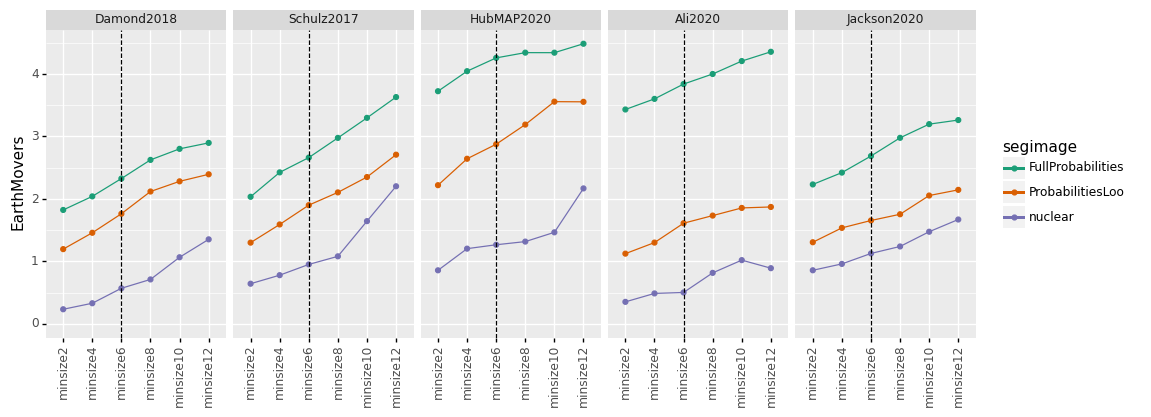

<ggplot: (8773976665239)>

In [92]:
(pdat.query('Neighbors_PercentTouching_Adjacent > 90')
 .groupby(['run','segsettings', 'segimage'])
 .apply(get_wasserstein).to_frame()
 .rename(columns={0: 'EarthMovers'})
 .reset_index()
 >>
    gg.ggplot(gg.aes(x='segsettings', y='EarthMovers',
                    color='segimage'))
      + gg.facet_grid('.~run')
     + gg.geom_line(gg.aes(group='segimage'))
     + gg.geom_point()
     + gg.expand_limits(y=0)
        +gg.geom_vline(xintercept=3, linetype = "dashed")
     + gg.scale_color_brewer(type='qual', palette=2)
     + gg.theme(axis_text_x = gg.element_text(angle = 90), 
                figure_size=(12,4))
     + gg.xlab('')
)


In [52]:
(pdat.query('Neighbors_PercentTouching_Adjacent > 90')
 .groupby(['run','segsettings', 'segimage'])
 .apply(get_wasserstein).to_frame()
 .rename(columns={0: 'EarthMovers'})
 .reset_index()
 >>
    gg.ggplot(gg.aes(x='segsettings', y='EarthMovers',
                    color='segimage'))
      + gg.facet_grid('.~run')
     + gg.geom_line(gg.aes(group='segimage'))
     + gg.geom_point()
     + gg.expand_limits(y=0)
)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (8774004237734)>

In [53]:
ioh.dat_img.query('ImageId == "Damond2018_1"')['PathName_Mask'].iloc[0]

NameError: name 'ioh' is not defined

In [ ]:
import centrosome.cpmorphology as cpmorph

In [ ]:
import matplotlib.colors as colors
import copy

In [ ]:
lab = ioh.get_image('"Damond2018_1"', 'LabelImg')
plt.imshow(lab)

In [ ]:
sd.ad_lab.var

In [ ]:
P

In [ ]:
plot_labels_on_mask(ioh, '"Damond2018_1"')

In [ ]:
mask.ndim


In [ ]:
mask = ioh.get_mask('"Damond2018_2"', 'LabelImg').astype(float)

In [ ]:
np.unique(mask)

In [ ]:
mask

In [ ]:

cur_seg = SegmentationData.from_runname('Damond2018', comparison_folder='seg_comparison_v4', image_categories=image_categories)

In [ ]:
sel_dat = (cur_seg.get_plot_data(['Intensity_MeanIntensity_MaskDistance'])
           .query('cropname == "M23_a0_x633_y429_w250_h250"'))

fig = cur_seg.plot_imag_ad(cur_seg.ad_lab[sel_dat.index,:][:, 'Intensity_MeanIntensity_MaskDistance'], bad_alpha=0,
                          add_colorbar=False)
ax = fig.axes[0]

ax.set_xlim((60,150))
ax.set_ylim((60,150))

In [ ]:
def plot_meas_all(segdat, var_name, cropname=None, obj_filter=None, fontsize=10):
    if cropname is None:
        cropname = segdat.ad_img.obs['cropname'].sample(1).values[0]
        print(cropname)
        
    d =segdat.ad_img.obs.query(f'cropname =="{cropname}"')[['segsettings', 'segimage']]
    
    fig, axs = plt.subplots(ncols=d['segsettings'].nunique(), nrows=d['segimage'].nunique(),sharex=True, sharey=True)
    for i, (segimage, g) in enumerate(d.groupby('segimage')):
        g = g['segsettings'].sort_values()
        for j, segsettings in enumerate(g):
            ax = axs[i][j]
            fil = segdat.ad_lab.obs.query(f'ImageId == "{g.index[j]}"')
            if obj_filter:
                fil = fil.query(obj_filter)
            segdat.plot_imag_ad(segdat.ad_lab[fil.index,:][:, var_name], ax=ax, add_colorbar=False)
            ax.set_title(segsettings, fontsize=fontsize)
            if j == 0:
                ax.xaxis.set_ticks([])
                ax.yaxis.set_ticks([])
                ax.set_ylabel(segimage, fontsize=fontsize)
            else:
                 ax.axis('off')
    return fig, axs

In [ ]:
fig, axs = plot_meas_all(cur_seg, 'Intensity_UpperQuartileIntensity_MaskDistance', cropname="M23_a0_x633_y429_w250_h250")
plth.adapt_ax_clims(axs.flatten(), imgnr=1)

In [ ]:
fig, axs = plot_meas_all(cur_seg, 'Intensity_UpperQuartileIntensity_MaskDistance', cropname="M23_a0_x633_y429_w250_h250")
plth.adapt_ax_clims(axs.flatten(), imgnr=1)
ax = axs[0][0]
ax.set_xlim((60,150))
ax.set_ylim((60,150))

In [ ]:
fig, axs = plot_meas_all(cur_seg, 'Intensity_UpperQuartileIntensity_MaskDistance', cropname="M23_a0_x633_y429_w250_h250",
                        obj_filter="label == 'center'")
plth.adapt_ax_clims(axs.flatten(), imgnr=1)
ax = axs[0][0]
ax.set_xlim((60,150))
ax.set_ylim((60,150))

In [ ]:
plt.colorbar(axs[0][0].images[1])

In [ ]:
axs[0][0].images[1].get_clim()

In [ ]:
axs[2][1].images[1].get_clim()